Our project involves predicting car crashes in Virginia 

In [ ]:
import sklearn
import numpy as np
import os
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

# Data Processing

In [ ]:
#crashes = pd.read_csv('https://filebin.net/wrmg77bm803etb1a/AllVirginiaCrash.csv?t=s60oqxmb')
crashes = pd.read_csv('AllVirginiaCrash.csv')
speed = pd.read_csv('VDOT_Speed_Limits.csv')
traffic = pd.read_csv('Virginia_Traffic_Volume.csv')
crashes.head()

,FID,FID_1,DOCUMENT_N,CRASH_YEAR,CRASH_DT,CRASH_MILI,CRASH_SEVE,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_IN,PEDESTRIAN,PEDESTRI_1,VEH_COUNT,COLLISION_,WEATHER_CO,LIGHT_COND,RD_TYPE,ROADWAY_SU,RELATION_T,ROADWAY_AL,ROADWAY__1,ROADWAY_DE,ROADWAY__2,INTERSECTI,TRAFFIC_CO,TRFC_CTRL_,WORK_ZONE_,WORK_ZON_1,WORK_ZON_2,FIRST_HARM,FIRST_HA_1,ALCOHOL_NO,BELTED_UNB,BIKE_NONBI,DISTRACTED,DEER_NODEE,DROWSY_NOT,DRUG_NODRU,GR_NOGR,HITRUN_NOT,LGTRUCK_NO,MOTOR_NONM,PED_NONPED,RR,SPEED_NOTS,SCHOOL_ZON,SENIOR_NOT,YOUNG_NOTY,MAINLINE_Y,NIGHT,VDOT_DISTR,JURIS_CODE,PHYSICAL_J,LOCAL_CASE,FUN,FAC,AREA_TYPE,SYSTEM,VSP,OWNERSHIP,INTERSEC_1,PLAN_DISTR,MPO_NAME,ROUTE_OR_S,RTE_NM,RNS_MP,NODE,OFFSET,LAT,LON
0,0,755424,190315149,2019,1/10/2019 0:00:00,1400,C,0,0,0,2,2,0,0,3,4,1,2,0,1,1,1,2,1,3,1,6,1,2,0,0,20,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,0,1,0,5,122,122,DIV519003398,A,3,1,1,5,1,0,23,HAMP,I - 64 WEST,R-VA IS00064WB,281.67,,0.00,36.881032,-76.210326
1,1,755425,190855040,2019,3/16/2019 0:00:00,1522,O,0,0,0,0,0,0,0,2,1,1,2,0,1,1,1,2,1,2,2,3,1,2,0,0,6,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,5,122,122,P19031600441,E,1,1,9,5,5,2,23,HAMP,1400 NORVIEW AVE,R-VA SR00247WB,4.94,483562,10.56,36.892152,-76.228672
2,2,755426,192145261,2019,8/2/2019 0:00:00,1301,O,0,0,0,0,0,0,0,2,2,1,2,0,1,8,1,2,1,2,1,4,1,2,0,0,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,1,0,9,253,253,2019-00027407,I,1,1,9,7,6,0,8,NOVA,EDWARDS FERRY ROAD,R-VA253UR04208WB,1.53,429758,802.56,39.113759,-77.534810
3,3,755427,193475098,2019,12/11/2019 0:00:00,1158,B,0,0,1,0,1,0,0,2,2,1,2,0,1,13,1,1,1,3,1,1,6,2,0,0,20,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,5,134,134,2019046859,H,1,1,9,5,6,2,23,HAMP,1100 FIRST COLONIAL ROAD,R-VA134UR00009NB,1.73,541256,174.24,36.866187,-76.029270
4,4,755428,191555292,2019,6/2/2019 0:00:00,1700,A,0,1,0,0,1,0,0,1,9,1,2,2,1,8,1,2,1,1,1,7,1,2,0,0,1,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,1,0,1,10,10,DIV419050428,4,0,0,2,4,2,0,3,,NB ROUTE 61,R-VA SR00061EB,27.52,153215,1272.48,37.244803,-81.097603


In [ ]:
speed = speed[['CAR_SPEED_', 'TRUCK_SPEE', 'ROUTE_COMM']]
traffic = traffic[['ADT', 'PERCENT_4_', 'PERCENT_BU', 'PERCENT_TR', 'PERCENT__1', 'PERCENT__2', 'PERCENT__3', 'FID', 'ROUTE_COMM', 'ROUTE_NAME']]
new = speed.merge(traffic, how='inner', on='ROUTE_COMM')
new = new.drop_duplicates(subset=['ROUTE_COMM'])
new2 = crashes.merge(new, how='left', left_on='RTE_NM', right_on='ROUTE_NAME')
new2.head()
crashes = new2
crashes = (crashes.drop(labels=['ADT', 'PERCENT_4_', 'PERCENT_BU', 'PERCENT_TR', 'PERCENT__1', 'PERCENT__2', 'PERCENT__3'], axis=1).join(crashes[['ADT', 'PERCENT_4_', 'PERCENT_BU', 'PERCENT_TR', 'PERCENT__1', 'PERCENT__2', 'PERCENT__3']].apply(pd.to_numeric, errors='coerce')))
#crashes = crashes.dropna()

In [ ]:
crashes.head(5)

,FID_x,FID_1,DOCUMENT_N,CRASH_YEAR,CRASH_DT,CRASH_MILI,CRASH_SEVE,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_IN,PEDESTRIAN,PEDESTRI_1,VEH_COUNT,COLLISION_,WEATHER_CO,LIGHT_COND,RD_TYPE,ROADWAY_SU,RELATION_T,ROADWAY_AL,ROADWAY__1,ROADWAY_DE,ROADWAY__2,INTERSECTI,TRAFFIC_CO,TRFC_CTRL_,WORK_ZONE_,WORK_ZON_1,WORK_ZON_2,FIRST_HARM,FIRST_HA_1,ALCOHOL_NO,BELTED_UNB,BIKE_NONBI,DISTRACTED,DEER_NODEE,DROWSY_NOT,DRUG_NODRU,...,PED_NONPED,RR,SPEED_NOTS,SCHOOL_ZON,SENIOR_NOT,YOUNG_NOTY,MAINLINE_Y,NIGHT,VDOT_DISTR,JURIS_CODE,PHYSICAL_J,LOCAL_CASE,FUN,FAC,AREA_TYPE,SYSTEM,VSP,OWNERSHIP,INTERSEC_1,PLAN_DISTR,MPO_NAME,ROUTE_OR_S,RTE_NM,RNS_MP,NODE,OFFSET,LAT,LON,CAR_SPEED_,TRUCK_SPEE,ROUTE_COMM,FID_y,ROUTE_NAME,ADT,PERCENT_4_,PERCENT_BU,PERCENT_TR,PERCENT__1,PERCENT__2,PERCENT__3
0,0,755424,190315149,2019,1/10/2019 0:00:00,1400,C,0,0,0,2,2,0,0,3,4,1,2,0,1,1,1,2,1,3,1,6,1,2,0,0,20,1,0,0,0,0,0,0,0,...,0,0,0,3,1,0,1,0,5,122,122,DIV519003398,A,3,1,1,5,1,0,23,HAMP,I - 64 WEST,R-VA IS00064WB,281.67,,0.00,36.881032,-76.210326,65.0,65.0,I-64W,34000.0,R-VA IS00064WB,87000.0,96.69957,0.55188,0.55118,0.33057,1.82993,0.04011
1,1,755425,190855040,2019,3/16/2019 0:00:00,1522,O,0,0,0,0,0,0,0,2,1,1,2,0,1,1,1,2,1,2,2,3,1,2,0,0,6,1,0,0,0,1,0,0,0,...,0,0,0,3,0,0,1,0,5,122,122,P19031600441,E,1,1,9,5,5,2,23,HAMP,1400 NORVIEW AVE,R-VA SR00247WB,4.94,483562,10.56,36.892152,-76.228672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,755426,192145261,2019,8/2/2019 0:00:00,1301,O,0,0,0,0,0,0,0,2,2,1,2,0,1,8,1,2,1,2,1,4,1,2,0,0,20,1,0,0,0,0,0,0,0,...,0,0,1,3,0,0,1,0,9,253,253,2019-00027407,I,1,1,9,7,6,0,8,NOVA,EDWARDS FERRY ROAD,R-VA253UR04208WB,1.53,429758,802.56,39.113759,-77.534810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,755427,193475098,2019,12/11/2019 0:00:00,1158,B,0,0,1,0,1,0,0,2,2,1,2,0,1,13,1,1,1,3,1,1,6,2,0,0,20,7,0,0,1,0,0,0,0,...,0,0,0,3,0,0,1,0,5,134,134,2019046859,H,1,1,9,5,6,2,23,HAMP,1100 FIRST COLONIAL ROAD,R-VA134UR00009NB,1.73,541256,174.24,36.866187,-76.029270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,755428,191555292,2019,6/2/2019 0:00:00,1700,A,0,1,0,0,1,0,0,1,9,1,2,2,1,8,1,2,1,1,1,7,1,2,0,0,1,4,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1,0,1,10,10,DIV419050428,4,0,0,2,4,2,0,3,,NB ROUTE 61,R-VA SR00061EB,27.52,153215,1272.48,37.244803,-81.097603,55.0,55.0,VA-61E,78550.0,R-VA SR00061EB,6000.0,97.68389,0.30516,0.75117,0.30517,0.95462,0.00000


In [ ]:
len(new2)

128164

In [ ]:
# Select relevant features
selected_all = crashes[['CRASH_SEVE', 'VEH_COUNT', 'COLLISION_', 'WEATHER_CO', 'LIGHT_COND', 'ROADWAY_SU', 'RD_TYPE', 'INTERSECTI', 'TRAFFIC_CO', 'WORK_ZONE_', 'ALCOHOL_NO', 'BELTED_UNB', 'DISTRACTED', 'DEER_NODEE', 'DROWSY_NOT', 'DRUG_NODRU', 'LGTRUCK_NO', 'MOTOR_NONM', 'PED_NONPED', 'SPEED_NOTS', 'SCHOOL_ZON', 'SENIOR_NOT', 'YOUNG_NOTY', 'NIGHT', 'VDOT_DISTR', 'CAR_SPEED_', 'TRUCK_SPEE', 'ADT', 'PERCENT_4_', 'PERCENT_BU', 'PERCENT_TR', 'PERCENT__1', 'PERCENT__2', 'PERCENT__3']]
selected = selected_all
selected.head()
# Train-Test Split
train, test = train_test_split(selected, test_size=0.2, random_state=42)#, stratify = selected['CRASH_SEVE'])
y_train_full = train['CRASH_SEVE'].copy()
X_train_pre = train.drop("CRASH_SEVE", axis=1)

In [ ]:
selected_all.head()

,CRASH_SEVE,VEH_COUNT,COLLISION_,WEATHER_CO,LIGHT_COND,ROADWAY_SU,RD_TYPE,INTERSECTI,TRAFFIC_CO,WORK_ZONE_,ALCOHOL_NO,BELTED_UNB,DISTRACTED,DEER_NODEE,DROWSY_NOT,DRUG_NODRU,LGTRUCK_NO,MOTOR_NONM,PED_NONPED,SPEED_NOTS,SCHOOL_ZON,SENIOR_NOT,YOUNG_NOTY,NIGHT,VDOT_DISTR,CAR_SPEED_,TRUCK_SPEE,ADT,PERCENT_4_,PERCENT_BU,PERCENT_TR,PERCENT__1,PERCENT__2,PERCENT__3
0,C,3,4,1,2,1,0,1,6,2,0,0,0,0,0,0,1,0,0,0,3,1,0,0,5,65.0,65.0,87000.0,96.69957,0.55188,0.55118,0.33057,1.82993,0.04011
1,O,2,1,1,2,1,0,2,3,2,0,0,1,0,0,0,0,0,0,0,3,0,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O,2,2,1,2,1,0,1,4,2,0,0,0,0,0,0,0,0,0,1,3,0,0,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B,2,2,1,2,1,0,1,1,2,0,0,0,0,0,0,0,0,0,0,3,0,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A,1,9,1,2,1,2,1,7,2,0,0,0,0,0,0,0,1,0,0,3,0,0,0,1,55.0,55.0,6000.0,97.68389,0.30516,0.75117,0.30517,0.95462,0.00000


In [ ]:
# Numerical Pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

In [ ]:
cat_attribs = ['WEATHER_CO', 'LIGHT_COND', 'ROADWAY_SU', 'RD_TYPE', 'TRAFFIC_CO', 'WORK_ZONE_', 'SCHOOL_ZON']
X_train_num = X_train_pre.drop(cat_attribs, axis=1)
X_train_cat = X_train_pre[cat_attribs].copy()
#X_train_num = X_train_num[X_train_num.apply(lambda x: x.isnumeric())]
num_attribs = list(X_train_num)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_full = full_pipeline.fit_transform(X_train_num.join(X_train_cat))

In [ ]:
print(X_train_pre.shape)
print(X_train_full.shape)

(102531, 33)
(102531, 80)


In [ ]:
# turns y__train / y_test into vectors of ints
# "K" = 0, "A" = 1, "B" = 2, "C" = 3, "O" = 4
def strToInt(y):
    newList = []
    table = {'K':0,'A':1,'B':2,'C':3,'O':4}
    for i in y:
        newList.append(table[i])
    return np.array(newList)
    
def strToIntBinary(y):
    newList = []
    table = {'K':1,'A':1,'B':0,'C':0,'O':0}
    for i in y:
        newList.append(table[i])
    return np.array(newList)

In [ ]:

y_test_pre = test['CRASH_SEVE'].copy()

X_test = test.drop("CRASH_SEVE", axis=1)
X_test = full_pipeline.transform(X_test)

print(X_train_full.shape)
print(y_train_full.shape)

'''# undersample
undersample = RandomUnderSampler(sampling_strategy='not minority')
X_train, y_train = undersample.fit_resample(X_train_full, y_train_full)
'''
'''# oversample

print(y_train_full)
X_train, y_train = oversample.fit_resample(X_train_full, y_train_full)
X_train, y_train = X_train_full, y_train_full'''

oversample = RandomOverSampler(sampling_strategy='not majority')  #={'K':20000,'A':20000,'C':20000})

y_train_full_pre = strToIntBinary(y_train_full)
y_test = strToIntBinary(y_test_pre)

X_train, y_train = oversample.fit_resample(X_train_full, y_train_full_pre)
#X_train, y_train = X_train_full, y_train_full_pre
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(102531, 80)
(102531,)
(194552, 80)
(194552,)
(25633, 80)
(25633,)


/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import collections
counter=collections.Counter(y_test)
print(counter)
print(counter.values())
counter=collections.Counter(y_train)
print(counter)
print(counter.values())

Counter({0: 24286, 1: 1347})
dict_values([24286, 1347])
Counter({0: 97276, 1: 97276})
dict_values([97276, 97276])


In [ ]:
def print_metrics(yt, yp):
    print('Accuracy:', accuracy_score(yt, yp))
    print('Recall:', recall_score(yt, yp, average = 'weighted'))
    print('Precision:', precision_score(yt, yp, average = 'weighted'))
    print('F1 Score:', f1_score(yt, yp, average = 'weighted'))

# Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsOneClassifier

# Training
log_reg = LogisticRegression(max_iter = 10000,class_weight={0:5,1:5})#, multi_class='multinomial')

log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 5, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:

# Prediction
y_predict = log_reg.predict(X_test)
confusion_matrix(y_test, y_predict)
y_train_predict = log_reg.predict(X_train)
confusion_matrix(y_train, y_train_predict)

array([[79550, 17726],
       [36320, 60956]])

In [ ]:
confusion_matrix(y_test, y_predict) #labels=["K", "A", "B", "C", "O"])

array([[19805,  4481],
       [  492,   855]])

In [ ]:
f1_score(y_test, y_predict, average='weighted')

0.8552133990599035

In [ ]:
print_metrics(y_test, y_predict)

Accuracy: 0.8059922755822573
Recall: 0.8059922755822573
Precision: 0.9329044403498156
F1 Score: 0.8552133990599035


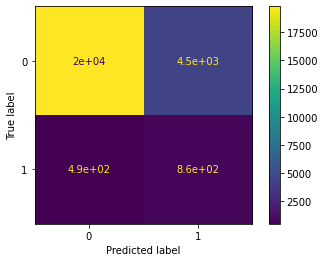

In [ ]:
plot_confusion_matrix(log_reg, X_test, y_test)

# SVM

In [ ]:
'''from sklearn.svm import SVC
rbf_clf = SVC(kernel='linear')
rbf_clf.fit(X_train, y_train)
y_pred = rbf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

plot_confusion_matrix(rbf_clf, X_test, y_test)
plt.show()'''

"from sklearn.svm import SVC\nrbf_clf = SVC(kernel='linear')\nrbf_clf.fit(X_train, y_train)\ny_pred = rbf_clf.predict(X_test)\nprint(classification_report(y_test, y_pred))\n\nprint('Recall:', recall_score(y_test, y_pred))\nprint('Precision:', precision_score(y_test, y_pred))\n\nplot_confusion_matrix(rbf_clf, X_test, y_test)\nplt.show()"


# K Nearest Neighbors

In [ ]:
'''from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print_metrics(y_test, y_pred)'''

'from sklearn.neighbors import KNeighborsClassifier\nneigh = KNeighborsClassifier(n_neighbors=2)\nneigh.fit(X_train, y_train)\ny_pred = neigh.predict(X_test)\nprint_metrics(y_test, y_pred)'

# Decision Trees

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     24286
           1       0.13      0.21      0.16      1347

    accuracy                           0.89     25633
   macro avg       0.54      0.57      0.55     25633
weighted avg       0.91      0.89      0.90     25633

Accuracy: 0.8854991612374673
Recall: 0.8854991612374673
Precision: 0.9117465805831352
F1 Score: 0.897864296801815


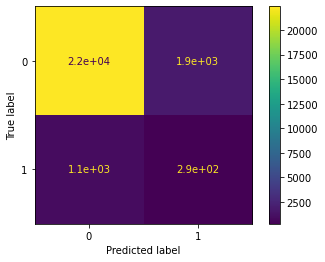

In [ ]:
print(y_test)
print(classification_report(y_test, y_pred))

print_metrics(y_test, y_pred)
plot_confusion_matrix(clf, X_test, y_test)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=1)
forest_clf.fit(X_train, y_train)

'''param_grid = [
    {'n_estimators': [50,100]},
  ]
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)'''
#grid_search.fit(X_train, y_train)
#forest_clf = grid_search.best_estimator_
y_forest_pred = forest_clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     24286
           1       0.16      0.18      0.17      1347

    accuracy                           0.91     25633
   macro avg       0.56      0.56      0.56     25633
weighted avg       0.91      0.91      0.91     25633

Accuracy: 0.9073850115086022
Recall: 0.9073850115086022
Precision: 0.9121083023570193
F1 Score: 0.909712847274087


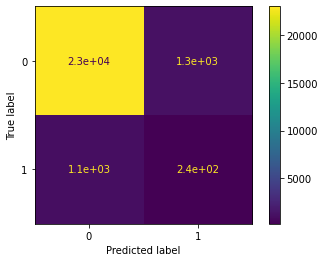

In [ ]:
print(classification_report(y_test, y_forest_pred))

print_metrics(y_test, y_forest_pred)

plot_confusion_matrix(forest_clf, X_test, y_test)

In [ ]:
print(cat_attribs)
print(num_attribs)

['WEATHER_CO', 'LIGHT_COND', 'ROADWAY_SU', 'RD_TYPE', 'TRAFFIC_CO', 'WORK_ZONE_', 'SCHOOL_ZON']
['VEH_COUNT', 'COLLISION_', 'INTERSECTI', 'ALCOHOL_NO', 'BELTED_UNB', 'DISTRACTED', 'DEER_NODEE', 'DROWSY_NOT', 'DRUG_NODRU', 'LGTRUCK_NO', 'MOTOR_NONM', 'PED_NONPED', 'SPEED_NOTS', 'SENIOR_NOT', 'YOUNG_NOTY', 'NIGHT', 'VDOT_DISTR', 'CAR_SPEED_', 'TRUCK_SPEE', 'ADT', 'PERCENT_4_', 'PERCENT_BU', 'PERCENT_TR', 'PERCENT__1', 'PERCENT__2', 'PERCENT__3']


In [ ]:
feature_importances = forest_clf.feature_importances_
print(feature_importances)
print(len(feature_importances))
attributes = num_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[4.01715308e-02 8.43105558e-02 4.12508440e-02 2.14788606e-02
 6.54891184e-02 2.59795543e-02 1.60359048e-02 7.20053105e-03
 4.02302853e-03 1.63590638e-02 4.54682166e-02 2.08379425e-02
 2.39112066e-02 2.14164552e-02 2.53199336e-02 1.02324038e-02
 9.38163652e-02 1.64103850e-02 1.66731890e-02 3.86616014e-02
 2.95611178e-02 3.01789704e-02 3.06827051e-02 3.08871855e-02
 3.00835115e-02 2.24815059e-02 6.93772256e-03 1.05850906e-03
 1.94500351e-03 5.78023799e-03 1.21349367e-03 4.25763481e-04
 7.69167023e-07 4.46894770e-04 1.29715621e-05 2.78752642e-05
 4.25708723e-03 1.20652983e-02 4.83458307e-03 8.22086546e-03
 8.99599640e-03 4.61669703e-04 5.58618216e-04 7.74516064e-03
 6.76304921e-03 7.25095498e-04 1.28327504e-03 2.28298771e-05
 2.55741127e-04 1.06213427e-04 2.92957903e-05 1.61265627e-04
 2.68920445e-04 4.43285683e-04 1.88283596e-02 6.34514693e-03
 7.35696661e-03 7.91428480e-03 1.10742545e-02 3.63882151e-04
 1.07843444e-02 7.69566803e-03 1.93074669e-03 1.63313888e-02
 8.77830848e-03 1.550272

[(0.09381636515642028, 'VDOT_DISTR'),
 (0.08431055575891444, 'COLLISION_'),
 (0.06548911838263255, 'BELTED_UNB'),
 (0.04546821663816083, 'MOTOR_NONM'),
 (0.04125084398659698, 'INTERSECTI'),
 (0.04017153084104938, 'VEH_COUNT'),
 (0.03866160143963562, 'ADT'),
 (0.03088718547009625, 'PERCENT__1'),
 (0.030682705106445295, 'PERCENT_TR'),
 (0.030178970426222262, 'PERCENT_BU'),
 (0.030083511539538185, 'PERCENT__2'),
 (0.02956111777032083, 'PERCENT_4_'),
 (0.02597955430887521, 'DISTRACTED'),
 (0.025319933555166402, 'YOUNG_NOTY'),
 (0.023911206632082734, 'SPEED_NOTS'),
 (0.02248150585524974, 'PERCENT__3'),
 (0.021478860553392307, 'ALCOHOL_NO'),
 (0.021416455162689214, 'SENIOR_NOT'),
 (0.020837942505724363, 'PED_NONPED'),
 (0.016673188992623038, 'TRUCK_SPEE'),
 (0.01641038497188762, 'CAR_SPEED_'),
 (0.016359063844602475, 'LGTRUCK_NO'),
 (0.01603590483519738, 'DEER_NODEE'),
 (0.010232403840027368, 'NIGHT'),
 (0.007200531045035592, 'DROWSY_NOT'),
 (0.004023028526238014, 'DRUG_NODRU')]

In [ ]:
sorted(zip([1,2,3],['a','b']))

[(1, 'a'), (2, 'b')]

# Neural Network

In [ ]:
nn_model = keras.Sequential()
nn_model.add(keras.layers.Dense(128, input_dim=80, activation='elu'))
nn_model.add(keras.layers.Dense(128, activation='elu'))
nn_model.add(keras.layers.Dense(128, activation='elu'))
nn_model.add(keras.layers.Dense(128, activation='elu'))
nn_model.add(keras.layers.Dense(128, activation='elu'))
nn_model.add(keras.layers.Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(type(X_train[0][0]))
print(type(y_train[0]))

nn_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100)

<class 'numpy.float64'>
<class 'numpy.int64'>
Epoch 1/100
6080/6080 [==============================] - 14s 2ms/step - loss: 0.5404 - accuracy: 0.7251 - val_loss: 0.5525 - val_accuracy: 0.7418
Epoch 2/100
6080/6080 [==============================] - 14s 2ms/step - loss: 0.5144 - accuracy: 0.7436 - val_loss: 0.4114 - val_accuracy: 0.8224
Epoch 3/100
6080/6080 [==============================] - 14s 2ms/step - loss: 0.4636 - accuracy: 0.7770 - val_loss: 0.3993 - val_accuracy: 0.8262
Epoch 4/100
6080/6080 [==============================] - 14s 2ms/step - loss: 0.3885 - accuracy: 0.8228 - val_loss: 0.4436 - val_accuracy: 0.8094
Epoch 5/100
6080/6080 [==============================] - 14s 2ms/step - loss: 0.3230 - accuracy: 0.8603 - val_loss: 0.4304 - val_accuracy: 0.8411
Epoch 6/100
6080/6080 [==============================] - 15s 2ms/step - loss: 0.2760 - accuracy: 0.8854 - val_loss: 0.5160 - val_accuracy: 0.8205
Epoch 7/100
6080/6080 [==============================] - 14s 2ms/step - loss: 

In [ ]:
print(X_test.shape)
print(y_test)
y_pred = nn_model.predict(X_train)
print(y_train[:-6])
print(y_pred[:-6])

(25633, 80)
[0 0 0 ... 0 0 0]


KeyboardInterrupt: ignored

In [ ]:
y_softmax = nn_model.predict(X_test)
y_pred = []
for i in range(len(y_softmax)):
    if(y_softmax[i][0] >y_softmax[i][1]): y_pred.append(0)
    else: y_pred.append(1)

y_pred = np.array(y_pred)
print(tf.math.confusion_matrix(y_test,y_pred))
print_metrics(y_test, y_pred)

tf.Tensor(
[[21666  2620]
 [  908   439]], shape=(2, 2), dtype=int32)
Accuracy: 0.8623649202200289
Recall: 0.8623649202200289
Precision: 0.9168824179964989
F1 Score: 0.8865905313763806
